In [47]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import math
import itertools
import scipy
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

import xgboost as xgb

from scipy.stats import chi2_contingency
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn import ensemble, metrics , datasets,tree
from sklearn.model_selection import train_test_split, cross_validate, learning_curve, StratifiedKFold, GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support

import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

Prepare

In [9]:
df = pd.read_csv('telco-customer-churn.csv')

df = df.drop('noadditionallines', axis=1)
dfc = df[['churn']]
d = {'High School or below':0,'Bachelor or equivalent':1,'Master or equivalent':2, 'PhD or equivalent':3}
fm = {'Male':0,'Female':1}
yn = {'No':0,'Yes':1}
sm = {'Single':0,'Married':1}
oc = {'Others':0,'Non-technology Related Job':1,'Technology Related Job':2}

df['education'] = df['education'].map(d)
df['gender'] = df['gender'].map(fm)
df['customersuspended'] = df['customersuspended'].map(yn)
df['homeowner'] = df['homeowner'].map(yn)
df['usesinternetservice'] = df['usesinternetservice'].map(yn)
df['usesvoiceservice'] = df['usesvoiceservice'].map(yn)
df['maritalstatus'] = df['maritalstatus'].map(sm)
df['occupation'] = df['occupation'].map(oc)

In [10]:
df.describe()

,age,annualincome,calldroprate,callfailurerate,callingnum,customerid,customersuspended,education,gender,homeowner,...,totalminsusedinlastmonth,unpaidbalance,usesinternetservice,usesvoiceservice,percentagecalloutsidenetwork,totalcallduration,avgcallduration,churn,year,month
count,20468.000000,20468.000000,20468.000000,20468.000000,2.046800e+04,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,...,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.0,20468.000000
mean,45.334327,124446.818253,0.035021,0.015239,4.220203e+09,4757.953342,0.978405,0.751319,0.511726,0.800274,...,249.740522,126.656879,0.038743,0.091362,0.496528,3521.696306,721.521057,0.091020,2015.0,1.611687
std,19.624577,72129.392001,0.022996,0.011213,3.365196e+08,2751.070062,0.145360,0.887094,0.499875,0.399804,...,144.198066,70.367800,0.192987,0.288130,0.288220,1959.642260,225.677596,0.287645,0.0,0.621895
min,12.000000,4.000000,0.000000,0.000000,1.022955e+08,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.0,1.000000
25%,28.000000,61898.000000,0.010000,0.010000,4.251031e+09,2372.750000,1.000000,0.000000,0.000000,1.000000,...,126.000000,66.000000,0.000000,0.000000,0.250000,2047.750000,582.000000,0.000000,2015.0,1.000000
50%,45.000000,123689.500000,0.040000,0.020000,4.251054e+09,4754.000000,1.000000,1.000000,1.000000,1.000000,...,249.000000,122.000000,0.000000,0.000000,0.500000,3365.000000,721.000000,0.000000,2015.0,2.000000
75%,62.000000,187065.250000,0.060000,0.030000,4.251077e+09,7141.250000,1.000000,1.000000,1.000000,1.000000,...,374.000000,191.000000,0.000000,0.000000,0.750000,4786.250000,862.000000,0.000000,2015.0,2.000000
max,79.000000,249987.000000,0.070000,0.030000,4.251100e+09,9525.000000,1.000000,3.000000,1.000000,1.000000,...,499.000000,249.000000,1.000000,1.000000,0.990000,16662.000000,1439.000000,1.000000,2015.0,3.000000


In [35]:
num_cols = ['totalminsusedinlastmonth', 'annualincome', 'calldroprate',
                           'monthlybilledamount','callfailurerate','numberofmonthunpaid',
                          'numdayscontractequipmentplanexpiring','penaltytoswitch',
                          'unpaidbalance', 'percentagecalloutsidenetwork',
                          'avgcallduration','days_in']

In [12]:
cat_cols = ['numberofcomplaints','education','gender','customersuspended',
            'homeowner','usesinternetservice','usesvoiceservice','maritalstatus','occupation']

In [13]:
df['new_churn'] = 0 # по дефолту для всех 0
churn_mask = df['churn'] == 1 # выделяем ушедших в отток
df.loc[churn_mask, 'new_churn'] = df[churn_mask].sort_values(['customerid', 'month']).groupby('customerid')['churn'].transform(lambda x: [0] * (len(x) - 1) + [1])
df.drop(['callingnum','customerid','churn','year'], axis=1, inplace = True)


Fold_1 = df[df['month'] == 1]
Fold_2 = df[df['month'] == 2]
Fold_3 = df[df['month'] == 3]

In [15]:
df['days_in'] = df['totalcallduration'] / df['avgcallduration']

### Визуальный и статистический анализ

In [16]:
# Рассмотрим взаимодействие категориального признака state, 50 различных значений
df.groupby(['state','new_churn'])['new_churn'].agg(['count']).head()
iterlist = [i for i in itertools.combinations(df.drop_duplicates(subset='state').state.values, 2)]

# Проверим, влияет ли штат абонента на целевую переменную
pt = df[['new_churn', 'state', 'age']].pivot_table(  columns='state' , index=['new_churn'],  aggfunc= 'count')['age']
pv = []
for i in iterlist:
    pv.append((chi2_contingency(pt[[i[0], i[1]]] , correction=False)[1], i))
    
imp = [i[1] for i in pv if i[0]<0.025]
imp_states = set(i[1] for i in imp)

# В 19 штатах соотношения статистически значимо
len(imp_states)

from collections import Counter
from heapq import nlargest
three_largest = nlargest(2,Counter([i[0] for i in imp]), key=Counter([i[0] for i in imp]).get)
three_largest2 = nlargest(2,Counter([i[1] for i in imp]), key=Counter([i[1] for i in imp]).get)

main_states = three_largest + three_largest2
main_states

['SC', 'CA', 'VT', 'NE']

Распределение num-признаков в группах churn

C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


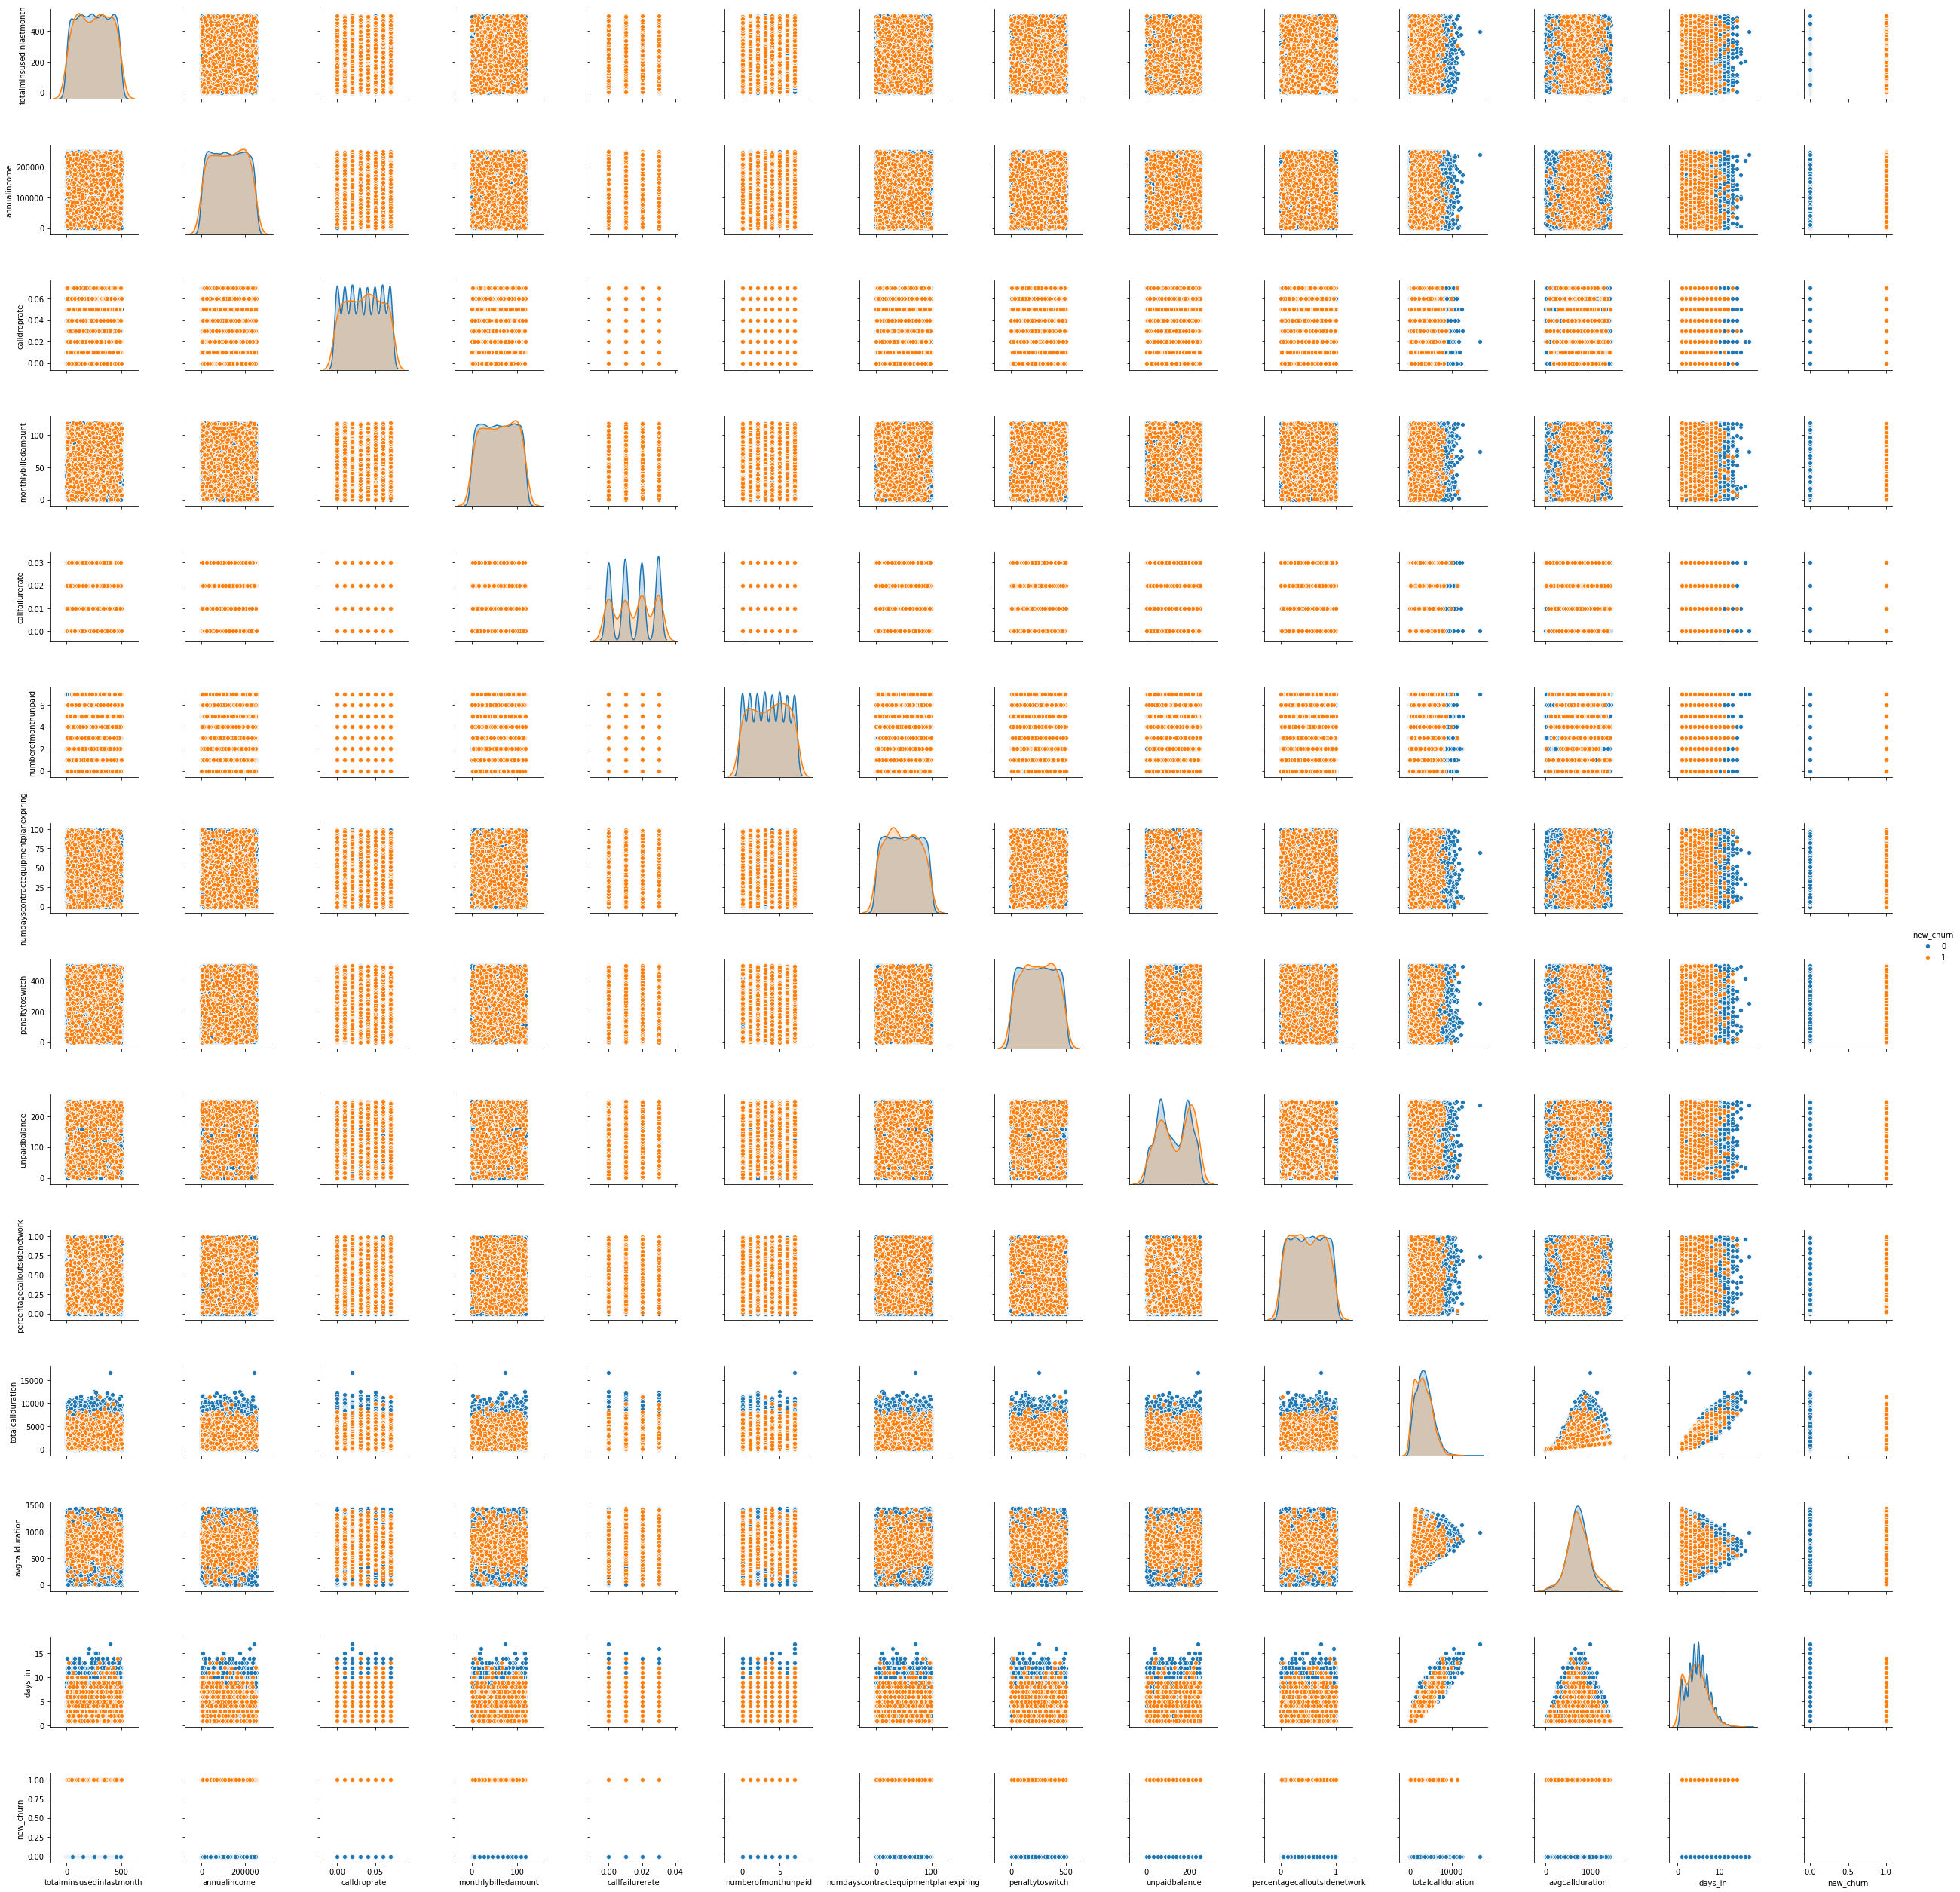

In [17]:
sns.pairplot(df[num_cols+['new_churn']], hue='new_churn', diag_kind="kde")

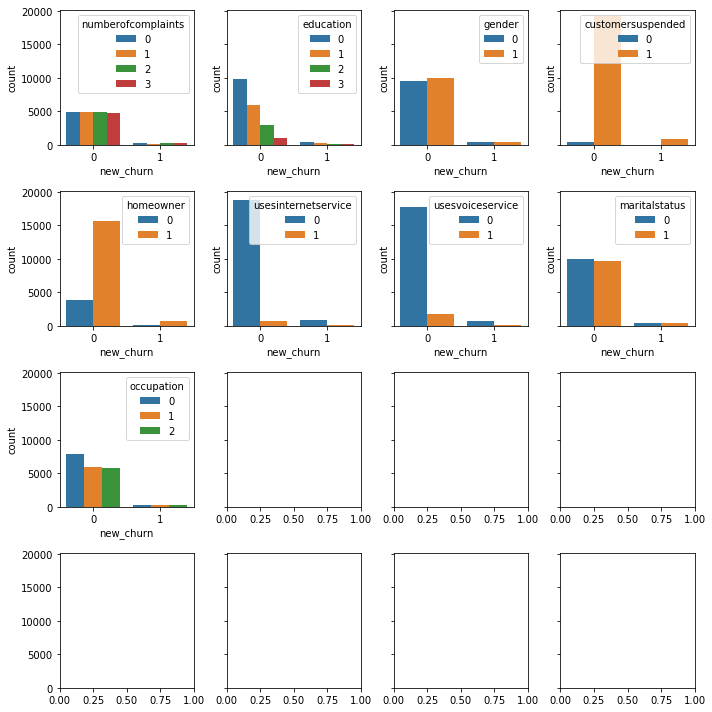

In [18]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10), sharey=True)
for i in range(len(cat_cols)):
    sns.countplot(x='new_churn', data=df, ax=axes[i // 4, i % 4], hue = cat_cols[i])
fig.tight_layout()

In [38]:
df0 = df[df.new_churn == 0]
df1 = df[df.new_churn == 1]

# Проверим отношение cat-признаков в целевых группах
# Возьмем признаки, которые коррелируют на уровне значимости 0.1
cat_pv_cols = [i for i in cat_cols if chi2_contingency(pd.DataFrame([np.bincount(df0[i]),np.bincount(df1[i])]))[1] <= 0.1]  
cat_pv_cols

['numberofcomplaints', 'education', 'maritalstatus']

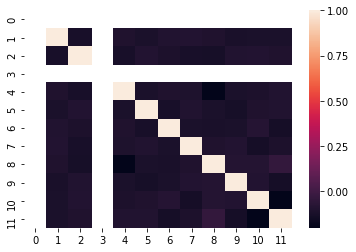

In [23]:
# Проверив корреляцию признаков
from scipy.stats import pearsonr, spearmanr

x = spearmanr(df[num_cols+['new_churn']])
df2 = pd.DataFrame.from_records(x[0])
correl = sns.heatmap(df2.corr())

In [36]:
# Проверим отличаются ли распределения num-признаков в целевых группах
# Возьмем признаки, которые коррелируют на уровне значимости < 0.1
num_pv_cols = [i for i in num_cols if stats.mannwhitneyu(df0[i], df1[i])[1] <= 0.1]
num_pv_cols

['numdayscontractequipmentplanexpiring',
 'unpaidbalance',
 'percentagecalloutsidenetwork',
 'avgcallduration',
 'days_in']

Рассмотрим признак age

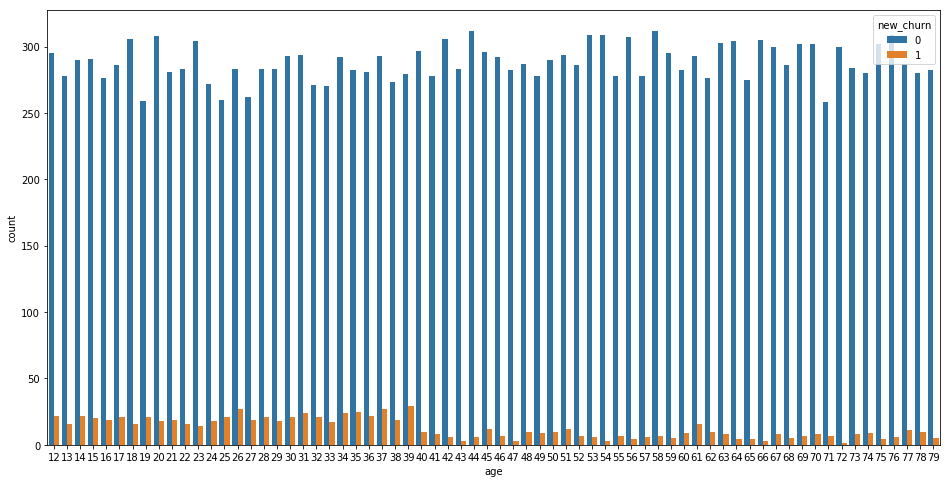

In [473]:
plt.figure(figsize=(16,8)) # this creates a figure 8 inch wide, 4 inch high
sns.countplot(x="age", hue = 'new_churn', data=df)
plt.show()

C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


1.8754352599397302e-37

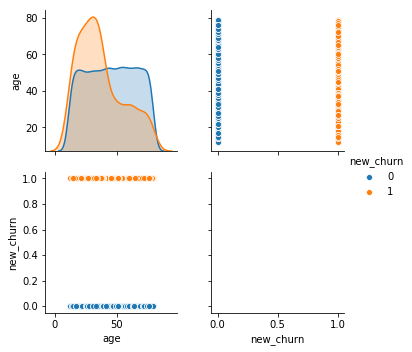

In [474]:
sns.pairplot(df[['age','new_churn']], hue='new_churn', diag_kind="kde")
stats.mannwhitneyu(df0['age'], df1['age'])[1]

Возраст сильно отличается в целевых группах, сгенерируем новый признак 0 если <= 40, 1 если > больше 40

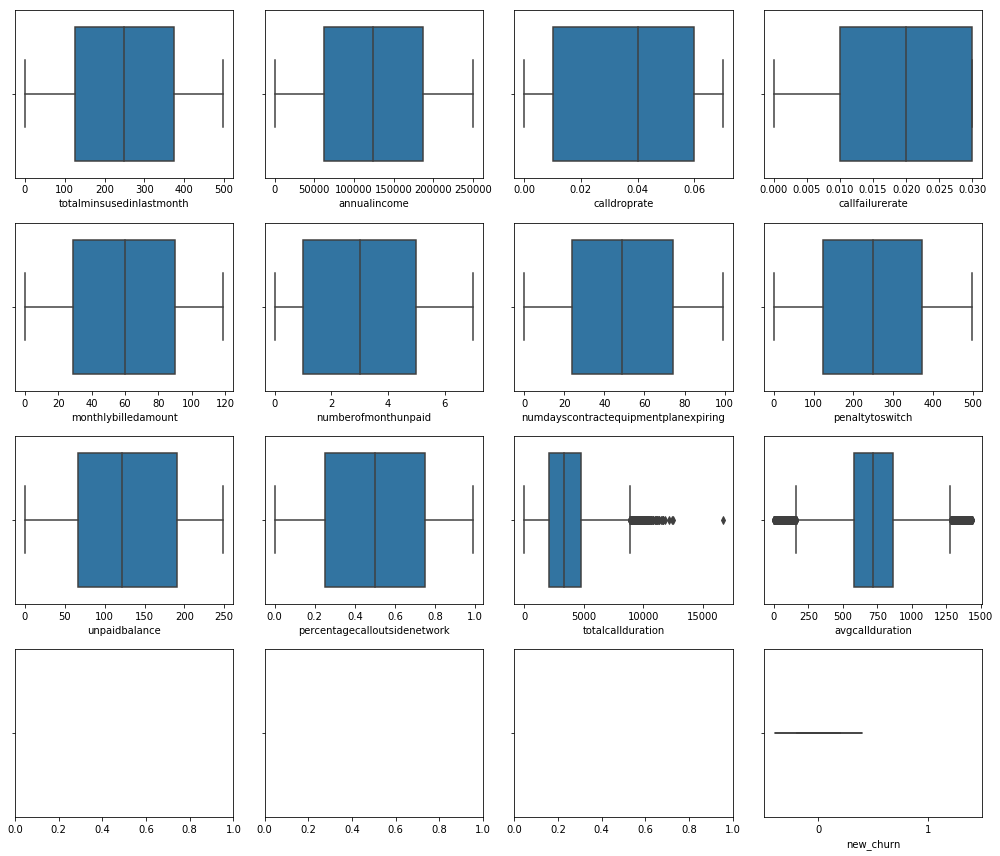

In [481]:
fig, axes = plt.subplots(4, 4, figsize=(14, 12), sharey=True)
for i in range(len(num_cols)):
    sns.boxplot(df[num_cols[i]], ax=axes[i // 4, i % 4])
    sns.boxplot(x='new_churn', y = i, data = df)
fig.tight_layout()

У признака totalcallduration большой правый хвост - абоненты, которые часто и много пользуются голосовыми сервисами.

In [39]:
# В поле State 50 типов значений, применим хеширование
df['state'] = (df['state']).map(hash) % 10000
# Добавим признак age40, удалим age
df['age40'] = df.age.apply(lambda x: 0 if x<40 else 1)
df['main_state'] = df.state.apply(lambda x: 1 if x in main_states else 0)

#OneHotEncoder
for (i) in df['education'].unique():
    df['education'+'_'+str(i)] = (df['education']==i).astype(int)
    cat_pv_cols.append('education'+'_'+str(i))

#df_d = df
df_d = df.drop(['education'] ,axis = 1)
cat_pv_cols.remove('education')
#cat_pv_cols.remove('numberofcomplaints')

In [40]:
df_fin = df_d[cat_pv_cols +num_pv_cols+['age40' ,'state', 'new_churn', 'month']]

Fold_1 = df_fin[df_fin['month'] == 1]
Fold_2 = df_fin[df_fin['month'] == 2]
Fold_3 = df_fin[df_fin['month'] == 3]

Fold_12 = df_fin[(df_fin['month'] == 1) | (df_fin['month'] == 2)]

In [1549]:
s=''
for i in Fold_2.columns:
    s+=i+'+'
    if i == 'month':
        break
s

'numberofcomplaints+maritalstatus+education_1+education_2+education_3+education_0+numdayscontractequipmentplanexpiring+unpaidbalance+percentagecalloutsidenetwork+totalcallduration+avgcallduration+age40+main_state+state+new_churn+month+'

In [1513]:
#import statsmodels.formula.api as smf
#m1 = smf.ols('new_churn ~ numberofcomplaints+education_1+education_2+education_3+education_0+maritalstatus+numdayscontractequipmentplanexpiring+unpaidbalance+percentagecalloutsidenetwork+totalcallduration+avgcallduration+age40+age+state',  data=Fold_2)
#fitted = m1.fit()

#print (fitted.summary())

In [41]:
y1 = Fold_1.new_churn
y2 = Fold_2.new_churn
y12 = Fold_12.new_churn
y3 = Fold_3.new_churn

Fold_1 = Fold_1.drop(['new_churn','month'] ,axis = 1)
Fold_2 = Fold_2.drop(['new_churn','month'] ,axis = 1)
Fold_3 = Fold_3.drop(['new_churn','month'] ,axis = 1)
Fold_12 = Fold_12.drop(['new_churn','month'] ,axis = 1)


cols = Fold_2.columns


z = pd.concat ([Fold_1, y1] ,sort=False, axis = 1)
a = z[z.iloc[:,-1]==0]
b = z[z.iloc[:,-1]==1]


a_under = a.sample(int(round(a.shape[0]/20,0)), random_state=42)
dfnew = pd.concat ([a_under,b])
Fold_1 = dfnew.iloc[:,:-1] 
y1 = dfnew.iloc[:,-1] 

In [42]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Fold_1 = sc.fit_transform(Fold_1)

sc = StandardScaler()
Fold_2 = sc.fit_transform(Fold_2)

sc = StandardScaler()
Fold_3 = sc.fit_transform(Fold_3)

sc = StandardScaler()
Fold_12 = sc.fit_transform(Fold_12)

C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_param

In [43]:
y1.value_counts()[0] / y1.value_counts()[1]

118.5

In [48]:
model = xgb.XGBClassifier(n_jobs=5, random_state=42,  tree_method ='approx')

param_search = {'max_depth': [3,4,5] ,
                'n_estimators': [90,120,150],
                'gamma': [0.01,0.05, 0.1],
                'scale_pos_weight': [25,50,100]
               }
skf = StratifiedKFold(n_splits=5)


gsearch = GridSearchCV(estimator=model, cv=skf, param_grid=param_search, scoring='f1_macro')
gsearch.fit(Fold_1, y1.values)
gsearch.best_estimator_

C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set 

C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\naroman7\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.01,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=90, n_jobs=5,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=50, seed=None,
       silent=None, subsample=1, tree_method='approx', verbosity=1)

In [49]:
model = xgb.XGBClassifier(n_jobs=5,max_depth=3, gamma=0.01,random_state=42,  
                          tree_method ='approx',n_estimators=90, scale_pos_weight=50)
model.fit(Fold_1, y1.values)

print(classification_report(y2.values, model.predict(Fold_2), target_names=['NoChurn', 'Churn']))

              precision    recall  f1-score   support

     NoChurn       0.93      0.99      0.96      8759
       Churn       0.04      0.00      0.01       707

   micro avg       0.92      0.92      0.92      9466
   macro avg       0.48      0.50      0.48      9466
weighted avg       0.86      0.92      0.89      9466



In [51]:
[(i,k) for i,k in zip(cols,model.feature_importances_)]

[('numberofcomplaints', 0.19136609),
 ('maritalstatus', 0.041908514),
 ('education_1', 0.0),
 ('education_2', 0.0),
 ('education_3', 0.021024298),
 ('education_0', 0.0),
 ('numdayscontractequipmentplanexpiring', 0.028147059),
 ('unpaidbalance', 0.050794706),
 ('percentagecalloutsidenetwork', 0.09180291),
 ('avgcallduration', 0.31997132),
 ('days_in', 0.17324232),
 ('age40', 0.026026579),
 ('main_state', 0.0),
 ('state', 0.055716146)]

In [52]:
y2.value_counts()[0] / y2.value_counts()[1]

12.38896746817539

In [53]:
param_search = {'max_depth': [5,6,7] ,
                'n_estimators': [180,250,300, 350],
                'gamma': [0.1, 0.5 , 1 , 2 ,5],
                'scale_pos_weight': [12.5]}
skf = StratifiedKFold(n_splits=5)


gsearch = GridSearchCV(estimator=model, cv=skf, param_grid=param_search, scoring='f1_macro')
gsearch.fit(Fold_2, y2.values)
gsearch.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.5,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=300, n_jobs=5,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=12.5, seed=None,
       silent=None, subsample=1, tree_method='approx', verbosity=1)

In [54]:
model.n_estimators=300
model.scale_pos_weight=12.5
model.gamma = 0.5
max_depth = 5
model.fit(Fold_2, y2.values)

print(classification_report(y3.values, model.predict(Fold_3), target_names=['NoChurn', 'Churn']))

              precision    recall  f1-score   support

     NoChurn       0.94      0.60      0.74      1377
       Churn       0.15      0.66      0.25       150

   micro avg       0.61      0.61      0.61      1527
   macro avg       0.55      0.63      0.49      1527
weighted avg       0.86      0.61      0.69      1527



In [55]:
[(i,k) for i,k in zip(cols,model.feature_importances_)]

[('numberofcomplaints', 0.19136533),
 ('maritalstatus', 0.02573393),
 ('education_1', 0.044601128),
 ('education_2', 0.04082251),
 ('education_3', 0.03444729),
 ('education_0', 0.026039843),
 ('numdayscontractequipmentplanexpiring', 0.027697578),
 ('unpaidbalance', 0.14060932),
 ('percentagecalloutsidenetwork', 0.032039315),
 ('avgcallduration', 0.03235418),
 ('days_in', 0.033140864),
 ('age40', 0.33957228),
 ('main_state', 0.0),
 ('state', 0.031576388)]

Confusion matrix, without normalization
[[1043  334]
 [  79   71]]


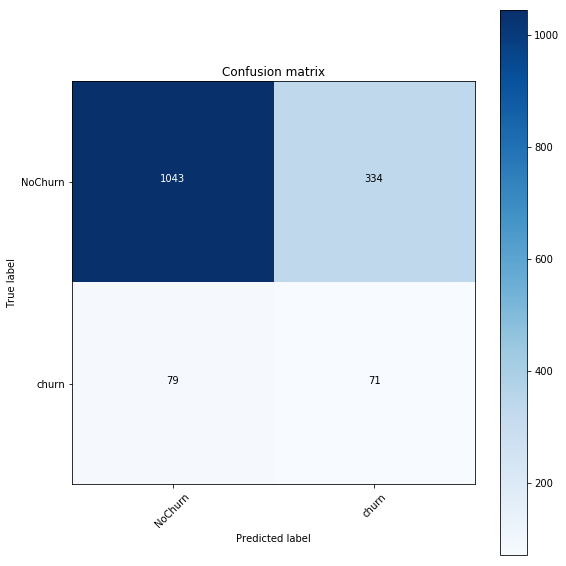

In [1556]:
# Функция для отрисовки матрицы
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cnf_matrix = confusion_matrix(y3.values, model.predict(Fold_3))
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['NoChurn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

# Learn & Predict

Модель применима с точки зрения отслеживания склонных к оттоку абонентов, однако следует выделять подгруппы абонентов из категории DoNotDisturbe, которых следует исключить.

На практике вероятно уменьшение качества, поскольку редко все признаки бывают известны и зачастую бывает большое количество пропусков.

Также следует учитывать сколько потенциальной прибыли могут принести абоненты и какие убытки можно понести при попытке удержания.

### Сводная ранжированная таблица для пользователей собравшихся уходить и для пользователей определенных моделью как "собравшихся уходить" (вероятность > 0.5)

In [56]:
prob = pd.DataFrame(model.predict_proba(Fold_3_v), columns=['NotChurn', 'Churn'])
predicts = pd.DataFrame(model.predict(Fold_3_v), columns=['predict'])

NameError: name 'Fold_3_v' is not defined

In [1397]:
users = pd.concat([prob, predicts, pd.DataFrame(y3.values)], axis=1)
u_churn = pd.merge(users.loc[users[0]==1], users.loc[users['predict']==1], how='outer').sort_values('Churn', ascending=False)
u_churn.head()

,NotChurn,Churn,predict,0
164,0.145310,0.854690,1,0
205,0.155538,0.844462,1,0
312,0.186432,0.813568,1,0
279,0.195253,0.804747,1,0
247,0.204352,0.795648,1,0


# Исходные данные

FN - количество пользователей ошибочно отнесенных к "остающимся"

FP - количество пользователей ошибочно отнесенных к "уходящим"

PPM - сколько денег в среднем приносит один пользователь в месяц

CFO - сколько денег в среднем вы будете вкладывать в удержание одного пользователя

PA - с какой вероятностью пользователь примет ваше предложение

NU - сколько пользователей будет участвовать в кампании

P - экономический эффект

$$
P = (NU - FP - FN) * PA * PPM + FP * PPM - CFO * (NU - FN) - FN * PPM * PA 
$$

In [1220]:
# Для начала расспотрим Топ-5% 
from collections import Counter

users1 = u_churn.head(int(u_churn.shape[0] * 0.01))
m = (users1[0] - users1['predict'])
c = Counter(m)
FN = c[1]
FP = c[-1]

In [1221]:
PPM = 60
CFO = 10
PA = 0.9
NU = users1.shape[0]

In [1222]:
P = (NU - FP - FN) * PA * PPM + FP * PPM - CFO * (NU - FN) - FN * PPM * PA

print ('Эффект в месяц от проведения кампании:', P)

Эффект в месяц от проведения кампании: 150.0


In [1223]:
perc = []
profit = []
n_users = []

for i in range(0, 100):
    users1 = u_churn.head(int(u_churn.shape[0]  * 0.01 * i))
    m = (users1[0] - users1['predict'])
    c = Counter(m)
    FN = c[1]
    FP = c[-1]
    NU = users1.shape[0]
    P = (NU - FP - FN) * PA * PPM + FP * PPM - CFO * (NU - FN) - FN * PPM * PA
    perc.append(i)
    profit.append(P)
    n_users.append(NU)

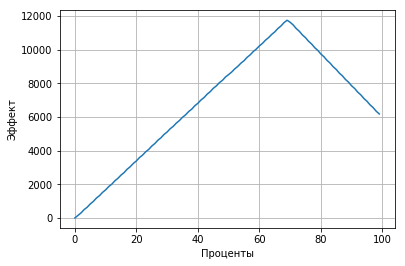

In [1224]:
plt.plot(perc, profit)
plt.xlabel(u'Проценты')
plt.ylabel(u'Эффект')
plt.grid(True)

In [1225]:
print ('Максимальный экономический эффект достигается при:', perc[np.argmax(profit)], 'процентах')
print ('Количество пользователей:', n_users[np.argmax(profit)])
print ('Максимальный экономический эффект в месяц:', np.max(profit))

Максимальный экономический эффект достигается при: 69 процентах
Количество пользователей: 240
Максимальный экономический эффект в месяц: 11754.0


Усложняем модель. К первоначальной формуле добавим зависимость стоимости удержания пользователя от того - принял он или нет предложение.

CFOY - затраты если принял предложение

CFON - затраты если отказался

$$
P = (NU - FP - FN) * PA * PPM + FP * PPM - CFOY * (NU - FN) * PA - CFON * (NU - FN) * (1 - PA) - FN * PPM * PA 
$$

Варьируем стоимость удержания и вероятность, с которой пользователь принимает предложение. Считаем, что чем дороже обходится удержание, тем выше вероятность принятия предложения.

199

In [1229]:
CFON = np.linspace(1, 10, 20)
CFOY = np.linspace(1, 25, 20)
PA = np.linspace(0, 0.9, 20)

perc = []
profit = []
n_users = []

for CFOY, CFON, PA in zip(CFOY, CFON, PA):
    users1 = u_churn.head(int(u_churn.shape[0] * 0.7))
    m = (users1[0] - users1['predict'])
    c = Counter(m)
    FN = c[-1]
    FP = c[1]
    NU = users1.shape[0]
    P = (NU - FP - FN) * PA * PPM + FP * PPM - CFOY * (NU - FN) * PA - CFON * (NU - FN) * (1 - PA) - FN * PPM * PA 
    profit.append(P)
    #print(P)

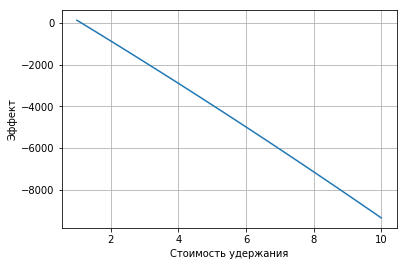

In [1230]:
plt.plot(np.linspace(1, 10, 20), profit)
plt.ylabel(u'Эффект')
plt.xlabel(u'Стоимость удержания')
plt.grid(True)

In [1228]:
print ('Максимальный экономический эффект достигается при затратах на удержание:', int(np.linspace(1, 10, 20)[np.argmax(profit)]))
print ('Что соответствует вероятности удержания:', int((np.linspace(0, 0.9, 10)[np.argmax(profit)])*100), '%')
print ('Максимальный экономический эффект в месяц:', int(np.max(profit)))
print ('Затраты на тех,кого не удалось удержать:', int(np.linspace(1, 10, 20)[np.argmax(profit)]))

Максимальный экономический эффект достигается при затратах на удержание: 1
Что соответствует вероятности удержания: 0 %
Максимальный экономический эффект в месяц: 135
Затраты на тех,кого не удалось удержать: 1


Естественно применение данной модели не всегда экономически оправдано. Если использовать слишком болльшую выборку участвующих пользователей, а так же применять неэффективную стратегию (сумма удержания выше оптимальной), то кампания будет идти в убыток.

In [57]:
CFON = 20
CFOY = 60
PA = 0.5

users1 = u_churn.head(int(u_churn.shape[0] * 0.5))
m = (users1[0] - users1['predict'])
c = Counter(m)
FN = c[1]
FP = c[-1]
NU = users1.shape[0]
P = (NU - FP - FN) * PA * PPM + FP * PPM - CFOY * (NU - FN) * PA - CFON * (NU - FN) * (1 - PA) - FN * PPM * PA 
P

-4410.0